In [1]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


import os
%matplotlib inline

## COMMON VOICE DATASET

### Deletar uma parte do dataset 

O common voice dataset contem muitos audios, vamos usar so uma parte para agilizar o treino!

In [3]:
# Varre o diretório e coleta todos os caminhos dos arquivos .wav
ct = 0
for root, dirs, files in os.walk("dataset/nao_ana"):
    for file in files:
        if file.endswith('.wav'):
            ct+=1
print(" Atualmente o dataset NAO ANA, tem ", ct)
            
'''
import os
import random

wav_files = []
dataset_path = './dataset/nao_ana/'

# todos os caminhos dos arquivos .wav
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith('.mp3'):
            wav_files.append(os.path.join(root, file))

# quantos arquivos devem ser deletados (50%)
num_files_to_delete = len(wav_files) // 2


files_to_delete = random.sample(wav_files, num_files_to_delete
for file_path in files_to_delete:
    os.remove(file_path)
    print(f"Arquivo deletado: {file_path}")

print(f"Total de arquivos deletados: {num_files_to_delete}")
'''

 Atualmente o dataset NAO ANA, tem  1010


'\nimport os\nimport random\n\nwav_files = []\ndataset_path = \'./dataset/nao_ana/\'\n\n# todos os caminhos dos arquivos .wav\nfor root, dirs, files in os.walk(dataset_path):\n    for file in files:\n        if file.endswith(\'.mp3\'):\n            wav_files.append(os.path.join(root, file))\n\n# quantos arquivos devem ser deletados (50%)\nnum_files_to_delete = len(wav_files) // 2\n\n\nfiles_to_delete = random.sample(wav_files, num_files_to_delete\nfor file_path in files_to_delete:\n    os.remove(file_path)\n    print(f"Arquivo deletado: {file_path}")\n\nprint(f"Total de arquivos deletados: {num_files_to_delete}")\n'

###  Configurar audios dataset 

Assegurar que o dataset esta com as mesmas configuracoes que os audios ANA, isso inclui ter: 1 canais, formato wav etc

In [11]:
'''
import ffmpeg
import wave
import os
from tqdm import tqdm

# Diretório onde os arquivos .mp3 estão localizados
dataset_dir = './dataset/nao_ana/'

mp3_files = []

# todos os caminhos dos arquivos .mp3
for root, dirs, files in os.walk(dataset_dir):
    for filename in files:
        if filename.endswith('.mp3'):
            mp3_files.append(os.path.join(root, filename))

# Cria e utiliza a barra de progresso do tqdm
for full_path in tqdm(mp3_files, desc="Convertendo arquivos .mp3 para .wav"):
    name_without_extension = os.path.splitext(os.path.basename(full_path))[0]
    
    # converte o arquivo para o formato desejado 
    out, _ = (ffmpeg
        .input(full_path)
        .output('-', format='s16le', acodec='pcm_s16le', ac=1, ar='22k')
        .overwrite_output()
        .run(capture_stdout=True)
    )

    CHANNELS = 1
    RATE = 22000
    swidth = 2

    # Salva o arquivo de áudio convertido como .wav
    wav_path = os.path.join(os.path.dirname(full_path), name_without_extension + '.wav')
    
    with wave.open(wav_path, 'wb') as wf:
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(swidth)
        wf.setframerate(RATE)
        wf.writeframes(out)

'''


Convertendo arquivos .mp3 para .wav: 0it [00:00, ?it/s]


## Spectogramas

In [5]:
y = []
x = []

paths = os.listdir('dataset')

print("labels ", paths)
classe = 0

for path in paths:
    path_name = os.path.join('./', 'dataset', path)
    for file in os.listdir(path_name):
        #audio
        filename = os.path.join(path_name, file)
        
        #carrega o audio
        audio, sr = librosa.load(filename, sr=22000, duration=3)
        
        #gera o spectograma
        S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=64)
        log_S = librosa.amplitude_to_db(S, ref=np.max) #log scale
        
        # adiciona array e label a X e Y
        x.append(log_S) 
        y.append(np.array(classe))
        
    # muda a classe    
    classe +=1


labels  ['ana', 'nao_ana']


In [6]:
# total de audios ( ana + nao ana)
len(x)

1042

In [7]:
# ------------- DELETAR AUDIOS DE TAMANHO DIFERENTE ! ------------------

# Copia original das listas
x_original = x.copy()
y_original = y.copy()

# Índices dos elementos a serem removidos
indices_to_remove = []

# Use enumerate para obter o índice e o elemento em x
for i, elem in enumerate(x_original):
    if elem.shape != (64, 129):
        indices_to_remove.append(i)  # Adiciona o índice à lista de remoção

# Remover elementos das listas originais, começando pelos maiores índices
ct =0
for idx in sorted(indices_to_remove, reverse=True):
    del x[idx]
    del y[idx]
    ct +=1
print(ct, " deletados")

242  deletados


In [8]:
x = np.array(x)
y = np.array(y)

In [9]:
x.shape

(800, 64, 129)

In [10]:
y.shape

(800,)

VAO SER UTILIZADOS UM TOTAL DE 800 AUDIOS, SENDO 32 DE ANA

## Model Trainning

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Input, Dropout, BatchNormalization, Convolution2D, MaxPool2D, GlobalMaxPool2D, Activation, Flatten, Reshape, ZeroPadding2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [12]:
y_c = to_categorical(y, num_classes=classe)
y_c
# ana = index 0
# outros = index 1

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    x.reshape(*x.shape, 1), y_c, test_size=0.33, random_state=22)

In [14]:
model = Sequential()

model.add(ZeroPadding2D(padding=(1,1),input_shape = (X_train.shape[1],X_train.shape[2],1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (4, 7)))
model.add(ZeroPadding2D(padding=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))

model.add(MaxPooling2D((3,3)))

model.add(ZeroPadding2D(padding=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(ZeroPadding2D(padding=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (4, 7)))

model.add(MaxPooling2D((3,3)))

model.add(ZeroPadding2D(padding=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(ZeroPadding2D(padding=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (4, 7)))

model.add(MaxPooling2D((3,3)))

model.add(ZeroPadding2D(padding=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(ZeroPadding2D(padding=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))

model.add(GlobalAveragePooling2D())


model.add(Dense(1024, activation='relu'))
model.add(Dense(classe))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 66, 131, 1)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 66, 131, 1)        4         
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 66, 131, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 63, 125, 32)       928       
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 65, 127, 32)       0         
 ing2D)                                                          
                                                        

In [15]:

history = model.fit(X_train, y_train, validation_split=0.3, batch_size= 32, epochs=100,
    callbacks=[
            EarlyStopping(patience=100, monitor="val_loss", verbose=1),
                          CSVLogger('voice_recognition.log')
])

Epoch 1/100
12/12 [==============================] - 44s 2s/step - loss: 0.5797 - accuracy: 0.8587 - val_loss: 0.3512 - val_accuracy: 0.9565
Epoch 2/100
12/12 [==============================] - 28s 2s/step - loss: 0.2324 - accuracy: 0.9520 - val_loss: 0.5014 - val_accuracy: 0.9565
Epoch 3/100
12/12 [==============================] - 23s 2s/step - loss: 0.0380 - accuracy: 0.9760 - val_loss: 0.9683 - val_accuracy: 0.0435
Epoch 4/100
12/12 [==============================] - 18s 2s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.8510 - val_accuracy: 0.0435
Epoch 5/100
12/12 [==============================] - 24s 2s/step - loss: 9.6397e-05 - accuracy: 1.0000 - val_loss: 3.0079 - val_accuracy: 0.0435
Epoch 6/100
12/12 [==============================] - 21s 2s/step - loss: 4.8422e-05 - accuracy: 1.0000 - val_loss: 3.9755 - val_accuracy: 0.0435
Epoch 7/100
12/12 [==============================] - 22s 2s/step - loss: 2.7300e-05 - accuracy: 1.0000 - val_loss: 4.7473 - val_accuracy: 0.0435
E

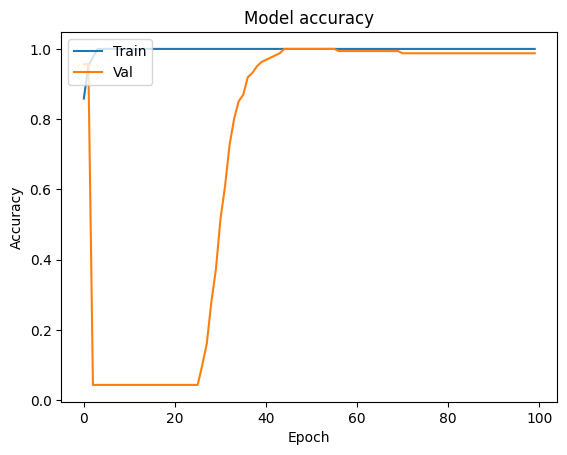

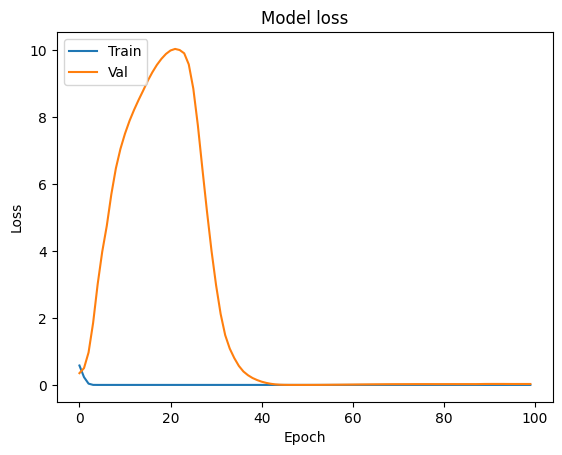

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [17]:
e = model.evaluate(X_test, y_test)

9/9 [==============================] - 2s 199ms/step - loss: 0.0131 - accuracy: 0.9962


In [18]:
e

[0.01314902026206255, 0.9962121248245239]

In [19]:
y_pred = model.predict(X_test)

9/9 [==============================] - 2s 227ms/step


In [20]:
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
y_p = np.argmax(y_pred, -1)

In [22]:
y_p

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
      dtype=int64)

In [23]:
y_t = np.argmax(y_test, -1)

In [24]:
y_t

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
      dtype=int64)

In [26]:
confusion_matrix(y_t, y_p)

array([[  9,   1],
       [  0, 254]], dtype=int64)

In [27]:
print(classification_report(y_t, y_p))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      1.00      1.00       254

    accuracy                           1.00       264
   macro avg       1.00      0.95      0.97       264
weighted avg       1.00      1.00      1.00       264



In [28]:
import pickle

pickle.dump(model, open('model.pkl', 'wb'))